# Custom campaign dummy

Template custom campaign which behaves exactly as SmartCampaignBase but provide the posibility of changing the logic.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Smart campaign definition

In [8]:
CAMPAIGN_DICT = {
    'name': "BasicSmartCampaign",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity    
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    #
    # Campaign definition
    #
    'alphas': {
        # Single alphas
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXO_PutSpread_DynKel_longs_DSP_BandPass__Bullish_2_Sept_7_21': {'tag': ''},
        
        # !! Risk reversal stack V1 + V2
        'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7__hedged': {
            'tag': '',
            'alphas': {
                'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXOSemiFuture_DynKel_20_60_longs_DSP_BandPass__Bullish_2_Sept_7_Oct_6': 1.0,
            }
        }
    }
}

### Loading smart campaign alphas

In [9]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = pd.DataFrame({k: v['swarm_series']['equity'] for k,v in alphas_series_dict.items()})


## Creating customized SmartCampaign

There are 3 main methods for SmartCampaign customization
- calc_alpha_risk(...) - calculates the risk of a particucular alpha equity in dollars
- compose_portfolio(...) - allows you to manage portfolio of alphas, by shutting down or managing alpha weights
- calc_campaign_risk(...) - calculates custom campaign risk 

In [10]:
class SmartCampaignCustom(SmartCampaignBase):    
    def calc_alpha_risk(self, alpha_equity):
        """
        Perform calculation of single alpha risk
        :param alpha_equity: alpha equity series
        :return: risk adjusted alpha equity series
        """
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_alpha_risk()
        return super().calc_alpha_risk(alpha_equity)
        
    def compose_portfolio(self, df_adj_alpha_equity: pd.DataFrame) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)
        :param df_adj_alpha_equity: Risk adjusted equity dataframe
        :return: dict[alpha_name: adj_alpha_size]                
        """
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.compose_portfolio()
        return super().compose_portfolio(df_adj_alpha_equity)
        
    def calc_campaign_risk(self, adj_campaign_equity) -> float:
        """
        Perform estimation of campaign risk
        :param adj_campaign_equity: cumulative campaign equity of composed alphas with adjusted weights
        :return: the estimated risk of campaign composition (float number)
        """ 
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_campaign_risk()
        return super().calc_campaign_risk(adj_campaign_equity)
        

# Backtesting

In [11]:
#
# Init Smart Campaign
#
scmp = SmartCampaignCustom(CAMPAIGN_DICT, df_alphas_equities)

BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

NetProfit $                     23732.65
NetProfit %                        47.47%

MaxDD $                        -21809.08
MaxDD %                           -33.41%

MaxATR $                          692.17
Q95% ATR $                        673.23
Avg ATR $                         598.82

MaxATR %                            1.07%
Q95% ATR %                          1.01%
Avg ATR %                           0.85%


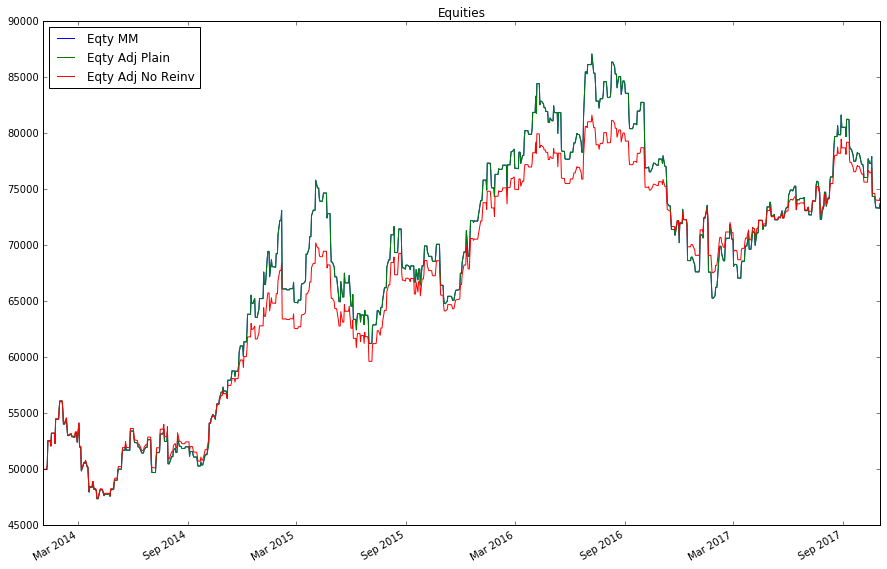

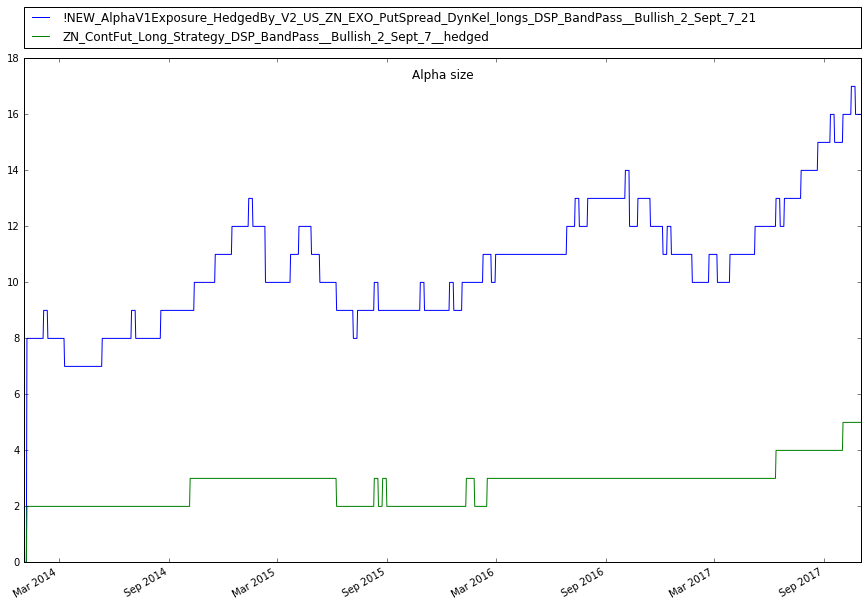

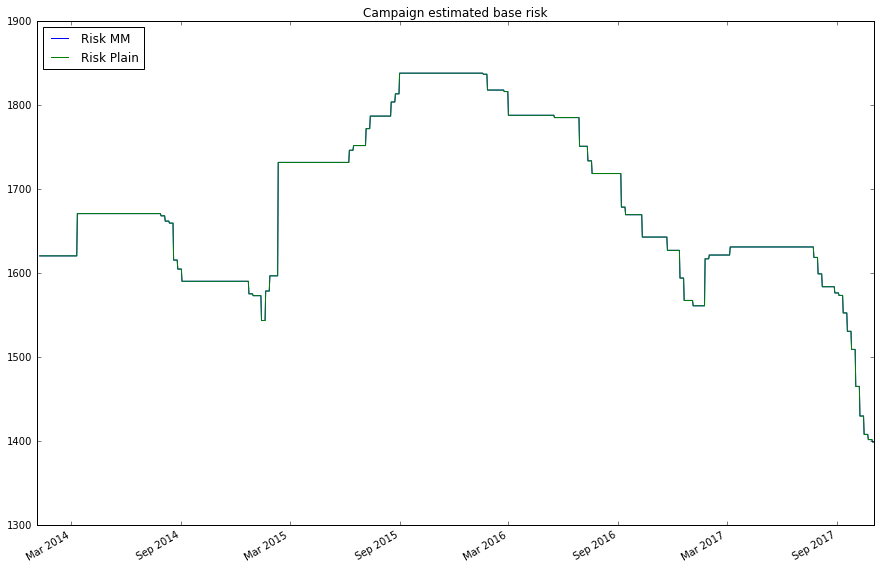

In [13]:
figsize(15, 10)
scmp.report(bt_dict)